## Init

In [1]:
repo = "https://github.com/ventus550/HandwritingRecognition"
! ! (git status 2> /dev/null) && git clone {repo}
%cd ShapeCorrection

On branch master
Your branch is ahead of 'origin/master' by 1 commit.
  (use "git push" to publish your local commits)

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
  (commit or discard the untracked or modified content in submodules)
	modified:   ../TkCanvas (modified content, untracked content)
	modified:   ETL.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	ETL_app.ipynb
	ETL_blur.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


[Errno 2] No such file or directory: 'ShapeCorrection'
/home/ventus/Documents/HandwritingRecognition/notebooks


In [2]:
import sys
sys.path.append("..")

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import skimage.exposure
import tensorflow as tf
from tqdm import tqdm
from pathlib import Path
from contextlib import suppress

2023-06-19 21:36:27.364893: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-19 21:36:27.640345: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-19 21:36:27.684834: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ventus/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-06-19 21:36:

## Configuration

In [4]:
BASEDIR = Path().absolute().parent
DESTDIR = BASEDIR / "data"
SRCDATA = DESTDIR / "handwritten"
DATASET = DESTDIR / "words_blur.npz"

In [5]:
image_width = 128
image_height = 32

## Load raw data

In [6]:
def read_legend(file = "words.txt"):
	lines = open(SRCDATA / file, "r").readlines()
	legend = list(filter(lambda s: s[0] != "#" and s.split(" ")[1] != "err", lines))
	np.random.shuffle(legend)
	return legend

In [7]:
def get_image_paths_and_labels(legend):
    paths = []
    corrected_samples = []
    for file_line in legend:
        line_split = file_line.split(" ")

        image_name = line_split[0]
        partI, partII = image_name.split("-")[:2]
        img_path = SRCDATA / partI / f"{partI}-{partII}" / f"{image_name}.png"
        if img_path.is_file():
            paths.append(str(img_path))
            corrected_samples.append(file_line.strip())
    return paths, [c.split()[-1] for c in corrected_samples]

In [8]:
read_legend()[:3]

['a04-089-08-07 ok 172 1922 2349 69 65 TO to\n',
 'g06-031p-06-02 ok 197 563 1801 176 54 NN mass\n',
 'm04-019-01-08 ok 171 1961 1076 99 115 INO of\n']

In [9]:
image_paths, image_labels = get_image_paths_and_labels(read_legend()[:1])
print(image_paths, image_labels)

['/home/ventus/Documents/HandwritingRecognition/data/handwritten/b04/b04-195/b04-195-00-08.png'] ['stories']


## Preprocessing

In [10]:
def bradley_roth_numpy(image, s=None, t=None):

	# Convert image to numpy array
	img = np.reshape(image, [32, 128]).astype(float)

	# Default window size is round(cols/8)
	if s is None:
		s = np.round(img.shape[1]/8)

	# Default threshold is 15% of the total
	# area in the window
	if t is None:
		t = 15.0

	# Compute integral image
	intImage = np.cumsum(np.cumsum(img, axis=1), axis=0)

	# Define grid of points
	(rows,cols) = img.shape[:2]
	(X,Y) = np.meshgrid(np.arange(cols), np.arange(rows))

	# Make into 1D grid of coordinates for easier access
	X = X.ravel()
	Y = Y.ravel()

	# Ensure s is even so that we are able to index into the image
	# properly
	s = s + np.mod(s,2)

	# Access the four corners of each neighbourhood
	x1 = X - s/2
	x2 = X + s/2
	y1 = Y - s/2
	y2 = Y + s/2

	# Ensure no coordinates are out of bounds
	x1[x1 < 0] = 0
	x2[x2 >= cols] = cols-1
	y1[y1 < 0] = 0
	y2[y2 >= rows] = rows-1

	# Ensures coordinates are integer
	x1 = x1.astype(int)
	x2 = x2.astype(int)
	y1 = y1.astype(int)
	y2 = y2.astype(int)

	# Count how many pixels are in each neighbourhood
	count = (x2 - x1) * (y2 - y1)

	# Compute the row and column coordinates to access
	# each corner of the neighbourhood for the integral image
	f1_x = x2
	f1_y = y2
	f2_x = x2
	f2_y = y1 - 1
	f2_y[f2_y < 0] = 0
	f3_x = x1-1
	f3_x[f3_x < 0] = 0
	f3_y = y2
	f4_x = f3_x
	f4_y = f2_y

	# Compute areas of each window
	sums = intImage[f1_y, f1_x] - intImage[f2_y, f2_x] - intImage[f3_y, f3_x] + intImage[f4_y, f4_x]

	# Compute thresholded image and reshape into a 2D grid
	out = np.ones(rows*cols, dtype=bool)
	out[img.ravel()*count <= sums*(100.0 - t)/100.0] = False

	# Also convert back to uint8
	out = 255*np.reshape(out, (rows, cols)).astype(np.uint8)
	return out

In [123]:
def load_image(image_path, image_height=image_height, image_width=image_width):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    return 255-tf.image.resize_with_pad(255-image, image_height, image_width)


def preprocess_image(image):
    image = 255 - bradley_roth_numpy(image, t = 21)
    image = np.round(image).astype(np.uint8)

    kernel = 7; sigma=0.58
    image = cv2.GaussianBlur(image, (kernel, kernel), sigmaX=sigma, sigmaY=sigma, borderType = cv2.BORDER_DEFAULT)
    image = skimage.exposure.rescale_intensity(image, in_range=(125.7,255), out_range=(0,255))
    image = image / 255.0
    # print(set(image.ravel()))
    return image


In [124]:
def sample(indices):
	image_paths, _ = get_image_paths_and_labels(read_legend())
	images = [1-load_image(image_paths[i]) for i in indices]
	preprocessed = [preprocess_image(1-im) for im in images]
	stack = [preprocessed[i//2] if i % 2 else images[i//2] for i in range(2*len(indices))]
	f, subs = plt.subplots(len(indices), 2, figsize=(8, len(indices)))
	for im, sb in zip(stack, subs.flatten()):
		sb.axis("off")
		sb.imshow(im, cmap="gray")

{0.0, 0.6906419180201082, 0.2652745552977571, 1.0, 0.791183294663573, 0.5282289249806651, 0.4818252126836813, 0.7370456303170919, 0.9535962877030162, 0.9071925754060324, 0.4354215003866975}
{0.0, 0.6906419180201082, 0.9535962877030162, 0.4818252126836813, 0.7370456303170919, 0.21887084300077336, 1.0, 0.6442382057231244, 0.5282289249806651, 0.9071925754060324, 0.791183294663573, 0.2652745552977571, 0.4354215003866975}
{0.0, 0.6906419180201082, 0.9535962877030162, 1.0, 0.791183294663573, 0.7370456303170919, 0.4818252126836813, 0.4354215003866975, 0.21887084300077336, 0.5282289249806651, 0.9071925754060324, 0.010054137664346458, 0.5746326372776488, 0.6442382057231244, 0.2652745552977571, 0.01778808971384375}
{0.0, 0.6906419180201082, 0.4818252126836813, 1.0, 0.7370456303170919, 0.9535962877030162, 0.4354215003866975, 0.5282289249806651, 0.9071925754060324, 0.791183294663573, 0.31941221964423816, 0.5746326372776488, 0.6442382057231244, 0.2652745552977571, 0.01778808971384375, 0.06419180201

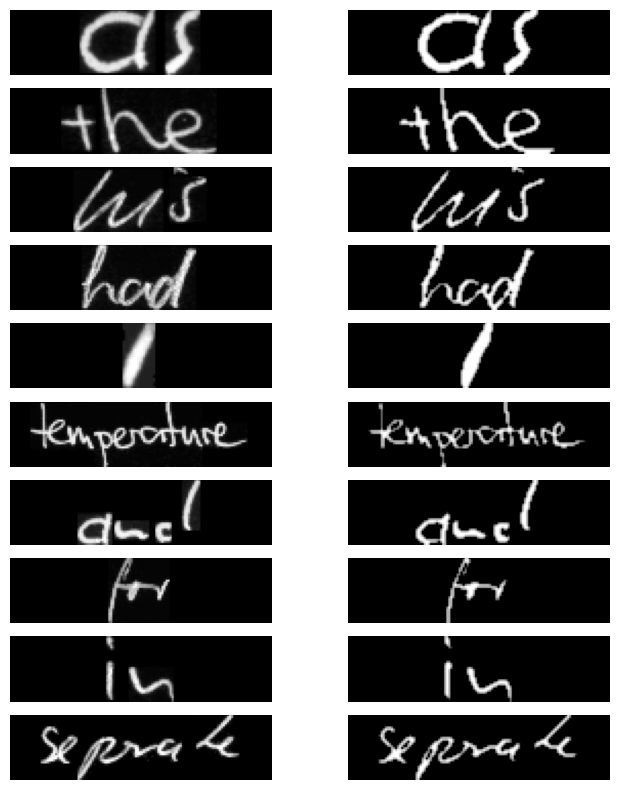

In [125]:
sample(np.arange(10))

## Save data

In [121]:
def prepare_dataset():
	X, Y = [], []
	image_paths, image_labels = get_image_paths_and_labels(read_legend())
	for path, label in tqdm(zip(image_paths, image_labels), total=len(image_paths)):
		with suppress(tf.errors.InvalidArgumentError):
			image = load_image(path)
			image = preprocess_image(image)
			X.append(image)
			Y.append(label)
	return np.array(X), np.array(Y)

In [126]:
%%time
X, Y = prepare_dataset()
np.savez(DATASET, images=X, labels=Y)

  0%|          | 41/96456 [00:00<07:58, 201.56it/s]

{0.0, 0.6906419180201082, 0.9535962877030162, 0.4818252126836813, 1.0, 0.4354215003866975, 0.7370456303170919, 0.5282289249806651, 0.9071925754060324}
{0.0, 0.6906419180201082, 0.9535962877030162, 0.4818252126836813, 0.7370456303170919, 1.0, 0.4354215003866975, 0.5282289249806651, 0.21887084300077336, 0.6442382057231244, 0.9071925754060324, 0.791183294663573, 0.1724671307037896}
{0.0, 0.2652745552977571, 0.6906419180201082, 0.9071925754060324, 0.7370456303170919, 0.4818252126836813, 0.4354215003866975, 0.5282289249806651, 0.9535962877030162, 1.0, 0.791183294663573}
{0.0, 0.6906419180201082, 0.2652745552977571, 0.4354215003866975, 0.4818252126836813, 0.7370456303170919, 0.9535962877030162, 1.0, 0.5282289249806651, 0.6442382057231244, 0.9071925754060324, 0.791183294663573, 0.21887084300077336, 0.1724671307037896}
{0.0, 0.791183294663573, 0.4818252126836813, 1.0, 0.7370456303170919, 0.9071925754060324, 0.6906419180201082, 0.5282289249806651, 0.2652745552977571, 0.21887084300077336, 0.9535

  0%|          | 62/96456 [00:00<08:10, 196.59it/s]

{0.0, 0.4818252126836813, 0.6906419180201082, 0.6442382057231244, 0.21887084300077336, 0.4354215003866975, 0.5282289249806651, 0.9071925754060324, 0.791183294663573, 0.7370456303170919, 0.9535962877030162, 0.3812838360402165, 1.0, 0.5978344934261407, 0.01778808971384375, 0.1724671307037896}
{0.0, 0.6906419180201082, 0.4818252126836813, 1.0, 0.7370456303170919, 0.9535962877030162, 0.4354215003866975, 0.5282289249806651, 0.2652745552977571, 0.791183294663573, 0.9071925754060324, 0.6442382057231244, 0.21887084300077336, 0.1724671307037896}
{0.0, 0.4818252126836813, 0.6442382057231244, 0.21887084300077336, 0.4354215003866975, 0.7370456303170919, 0.6906419180201082, 0.9071925754060324, 0.5282289249806651, 0.9535962877030162, 1.0, 0.791183294663573, 0.5746326372776488, 0.2652745552977571, 0.01778808971384375}
{0.0, 0.4818252126836813, 0.5282289249806651, 0.4354215003866975, 0.6442382057231244, 0.9071925754060324, 0.9535962877030162, 0.6906419180201082, 0.7370456303170919, 0.3812838360402165,

  0%|          | 100/96456 [00:00<09:49, 163.35it/s]

{0.0, 0.6906419180201082, 0.1724671307037896, 0.21887084300077336, 1.0, 0.2652745552977571, 0.4818252126836813, 0.6442382057231244, 0.7370456303170919, 0.9535962877030162, 0.31941221964423816, 0.010054137664346458, 0.791183294663573, 0.9071925754060324, 0.8530549110595513, 0.5282289249806651, 0.4354215003866975}
{0.0, 0.791183294663573, 0.2652745552977571, 0.9071925754060324, 0.4818252126836813, 0.5282289249806651, 0.21887084300077336, 0.3812838360402165, 0.1724671307037896, 0.6442382057231244, 0.9535962877030162, 0.5746326372776488, 0.4354215003866975, 0.7370456303170919, 0.056457849961330214, 0.6906419180201082, 0.10286156225831397, 0.010054137664346458, 0.5978344934261407, 0.01778808971384375, 0.31941221964423816, 0.8530549110595513}
{0.0, 0.6906419180201082, 0.9535962877030162, 0.4818252126836813, 0.7370456303170919, 0.21887084300077336, 0.6442382057231244, 0.5282289249806651, 0.4354215003866975, 0.9071925754060324, 1.0, 0.791183294663573, 0.2652745552977571}
{0.0, 0.79118329466357

  0%|          | 134/96456 [00:00<09:41, 165.54it/s]

{0.0, 0.791183294663573, 0.6906419180201082, 0.4818252126836813, 1.0, 0.9535962877030162, 0.7370456303170919, 0.6442382057231244, 0.5282289249806651, 0.4354215003866975, 0.5746326372776488, 0.9071925754060324, 0.2652745552977571, 0.8530549110595513, 0.21887084300077336, 0.01778808971384375, 0.06419180201082751}
{0.0, 0.4818252126836813, 0.6442382057231244, 0.3812838360402165, 0.4354215003866975, 0.6906419180201082, 0.7370456303170919, 0.9071925754060324, 1.0, 0.5282289249806651, 0.791183294663573, 0.21887084300077336, 0.1724671307037896, 0.9535962877030162}
{0.0, 0.6906419180201082, 0.4354215003866975, 0.4818252126836813, 1.0, 0.9535962877030162, 0.7370456303170919, 0.5282289249806651, 0.6442382057231244, 0.791183294663573, 0.9071925754060324, 0.2652745552977571, 0.21887084300077336}
{0.0, 0.4818252126836813, 0.6906419180201082, 0.21887084300077336, 0.6442382057231244, 0.5282289249806651, 0.9071925754060324, 0.4354215003866975, 0.7370456303170919, 1.0, 0.791183294663573, 0.381283836040

  0%|          | 169/96456 [00:00<09:45, 164.40it/s]

{0.0, 0.6906419180201082, 0.1724671307037896, 0.4818252126836813, 0.791183294663573, 0.9071925754060324, 0.2652745552977571, 0.6442382057231244, 0.4354215003866975, 0.7370456303170919, 0.9535962877030162, 1.0, 0.3812838360402165, 0.5282289249806651, 0.21887084300077336}
{0.0, 0.791183294663573, 0.6906419180201082, 0.9071925754060324, 0.4818252126836813, 0.7370456303170919, 0.6442382057231244, 0.2652745552977571, 0.5282289249806651, 0.8066511987625676, 1.0, 0.3812838360402165, 0.8530549110595513, 0.4354215003866975, 0.21887084300077336, 0.1724671307037896, 0.9535962877030162}
{0.0, 0.791183294663573, 0.6906419180201082, 0.4818252126836813, 1.0, 0.7370456303170919, 0.9535962877030162, 0.5282289249806651, 0.9071925754060324, 0.21887084300077336, 0.6442382057231244, 0.2652745552977571, 0.4354215003866975}
{0.0, 0.4818252126836813, 0.9535962877030162, 0.6906419180201082, 0.7370456303170919, 1.0, 0.4354215003866975, 0.5282289249806651, 0.21887084300077336, 0.791183294663573, 0.64423820572312

  0%|          | 204/96456 [00:01<09:49, 163.17it/s]

{0.0, 0.791183294663573, 0.5282289249806651, 0.6906419180201082, 0.9071925754060324, 0.4818252126836813, 0.9535962877030162, 0.7370456303170919, 1.0, 0.2652745552977571, 0.6442382057231244, 0.5746326372776488, 0.3812838360402165, 0.8530549110595513, 0.4354215003866975, 0.21887084300077336, 0.01778808971384375}
{0.0, 0.5978344934261407, 0.2652745552977571, 0.4354215003866975, 0.4818252126836813, 0.1724671307037896, 0.3812838360402165, 0.21887084300077336, 0.6442382057231244, 0.6906419180201082, 0.056457849961330214, 1.0, 0.791183294663573, 0.9071925754060324, 0.5282289249806651, 0.8530549110595513, 0.7370456303170919, 0.9535962877030162}
{0.0, 0.4818252126836813, 0.2652745552977571, 0.6906419180201082, 0.7370456303170919, 0.9535962877030162, 1.0, 0.6442382057231244, 0.5282289249806651, 0.9071925754060324, 0.791183294663573, 0.4354215003866975, 0.21887084300077336, 0.06419180201082751}
{0.0, 0.6906419180201082, 0.6442382057231244, 0.21887084300077336, 0.7370456303170919, 0.52822892498066

  0%|          | 243/96456 [00:01<08:59, 178.40it/s]

{0.0, 0.4818252126836813, 0.6442382057231244, 0.3812838360402165, 0.4354215003866975, 0.6906419180201082, 0.7370456303170919, 0.21887084300077336, 0.2652745552977571, 0.9535962877030162, 0.31941221964423816, 1.0, 0.791183294663573, 0.9071925754060324, 0.5282289249806651, 0.01778808971384375}
{0.0, 0.4818252126836813, 0.1724671307037896, 0.6906419180201082, 0.4354215003866975, 0.9071925754060324, 0.21887084300077336, 0.7370456303170919, 0.2652745552977571, 0.6442382057231244, 0.9535962877030162, 1.0, 0.791183294663573, 0.31941221964423816, 0.3812838360402165, 0.5746326372776488, 0.5282289249806651, 0.8530549110595513}
{0.0, 0.5746326372776488, 0.9071925754060324, 0.6906419180201082, 0.4818252126836813, 1.0, 0.7370456303170919, 0.4354215003866975, 0.2652745552977571, 0.6442382057231244, 0.9535962877030162, 0.791183294663573, 0.056457849961330214, 0.5282289249806651, 0.8530549110595513, 0.21887084300077336, 0.06419180201082751}
{0.0, 0.1724671307037896, 0.2652745552977571, 0.2188708430007

  0%|          | 281/96456 [00:01<08:51, 181.02it/s]

{0.0, 0.6906419180201082, 0.4818252126836813, 1.0, 0.4354215003866975, 0.7370456303170919, 0.9535962877030162, 0.5282289249806651, 0.791183294663573, 0.9071925754060324, 0.5746326372776488, 0.2652745552977571}
{0.0, 0.6906419180201082, 0.9535962877030162, 0.4818252126836813, 0.791183294663573, 1.0, 0.7370456303170919, 0.5282289249806651, 0.2652745552977571, 0.9071925754060324, 0.4354215003866975}
{0.0, 0.791183294663573, 0.9535962877030162, 0.6906419180201082, 0.4818252126836813, 1.0, 0.7370456303170919, 0.4354215003866975, 0.2652745552977571, 0.21887084300077336, 0.9071925754060324, 0.5978344934261407, 0.6442382057231244, 0.31941221964423816, 0.5282289249806651, 0.8530549110595513, 0.06419180201082751}
{0.0, 0.6906419180201082, 0.4354215003866975, 1.0, 0.7370456303170919, 0.4818252126836813, 0.9535962877030162, 0.5282289249806651, 0.2652745552977571, 0.9071925754060324, 0.791183294663573}
{0.0, 0.4818252126836813, 0.6442382057231244, 0.4354215003866975, 0.7370456303170919, 0.690641918

  0%|          | 321/96456 [00:01<08:27, 189.35it/s]

{0.0, 0.2652745552977571, 0.6906419180201082, 0.9071925754060324, 0.7370456303170919, 0.4818252126836813, 0.9535962877030162, 0.5282289249806651, 1.0, 0.4354215003866975, 0.791183294663573, 0.6442382057231244, 0.21887084300077336, 0.1724671307037896}
{0.0, 0.6906419180201082, 0.9535962877030162, 0.4354215003866975, 0.791183294663573, 0.4818252126836813, 0.7370456303170919, 1.0, 0.9071925754060324}
{0.0, 0.4818252126836813, 0.6906419180201082, 0.6442382057231244, 0.4354215003866975, 0.7370456303170919, 0.9071925754060324, 0.9535962877030162, 1.0, 0.5282289249806651, 0.791183294663573, 0.1724671307037896}
{0.0, 0.4818252126836813, 0.6906419180201082, 0.6442382057231244, 0.4354215003866975, 0.7370456303170919, 0.9535962877030162, 1.0, 0.21887084300077336, 0.5282289249806651, 0.9071925754060324, 0.5978344934261407, 0.791183294663573, 0.3812838360402165, 0.010054137664346458, 0.2652745552977571}
{0.0, 0.2652745552977571, 0.6906419180201082, 0.4818252126836813, 0.7370456303170919, 0.95359628

  0%|          | 340/96456 [00:01<08:39, 184.97it/s]

{0.0, 0.2652745552977571, 0.5282289249806651, 0.9071925754060324, 0.4818252126836813, 0.7370456303170919, 0.9535962877030162, 1.0, 0.791183294663573, 0.6906419180201082, 0.6442382057231244, 0.4354215003866975, 0.21887084300077336}
{0.0, 0.4818252126836813, 0.6442382057231244, 0.6906419180201082, 0.4354215003866975, 0.7370456303170919, 0.5282289249806651, 0.21887084300077336, 0.9071925754060324, 0.010054137664346458, 0.5746326372776488, 1.0, 0.791183294663573, 0.2652745552977571, 0.06419180201082751, 0.9535962877030162}
{0.0, 0.5746326372776488, 0.5282289249806651, 0.4818252126836813, 0.9071925754060324, 0.6906419180201082, 0.7370456303170919, 0.6442382057231244, 0.4354215003866975, 0.9535962877030162, 1.0, 0.791183294663573, 0.2652745552977571, 0.21887084300077336, 0.1724671307037896}
{0.0, 0.6906419180201082, 0.6442382057231244, 0.4354215003866975, 0.4818252126836813, 0.3812838360402165, 0.21887084300077336, 0.056457849961330214, 0.2652745552977571, 0.1724671307037896}
{0.0, 0.6906419

  0%|          | 377/96456 [00:02<09:12, 173.86it/s]

{0.0, 0.6906419180201082, 0.4354215003866975, 1.0, 0.7370456303170919, 0.21887084300077336, 0.9535962877030162, 0.5282289249806651, 0.4818252126836813, 0.6442382057231244, 0.791183294663573, 0.3812838360402165, 0.1724671307037896}
{0.0, 0.6906419180201082, 0.4354215003866975, 1.0, 0.7370456303170919, 0.9535962877030162, 0.4818252126836813, 0.5282289249806651, 0.791183294663573, 0.21887084300077336, 0.9071925754060324, 0.2652745552977571}
{0.0, 0.4818252126836813, 0.5282289249806651, 0.6906419180201082, 0.6442382057231244, 0.4354215003866975, 0.9071925754060324, 0.9535962877030162, 0.21887084300077336, 0.7370456303170919, 0.791183294663573, 1.0, 0.5746326372776488, 0.31941221964423816, 0.2652745552977571, 0.01778808971384375, 0.1724671307037896, 0.06419180201082751}
{0.0, 0.6906419180201082, 0.9535962877030162, 0.4818252126836813, 0.7370456303170919, 1.0, 0.4354215003866975, 0.5282289249806651, 0.791183294663573}
{0.0, 0.791183294663573, 0.5282289249806651, 0.6906419180201082, 0.9535962

  0%|          | 413/96456 [00:02<09:17, 172.33it/s]

{0.0, 0.791183294663573, 0.5282289249806651, 0.6906419180201082, 0.9535962877030162, 1.0, 0.4818252126836813, 0.7370456303170919}
{0.0, 0.6442382057231244, 0.4818252126836813, 0.3812838360402165, 0.4354215003866975, 0.6906419180201082, 0.21887084300077336, 0.791183294663573, 0.9535962877030162, 0.7370456303170919, 1.0, 0.5978344934261407, 0.5282289249806651, 0.2652745552977571, 0.1724671307037896}
{0.0, 0.4818252126836813, 0.1724671307037896, 0.4354215003866975, 0.3812838360402165, 0.21887084300077336, 0.5978344934261407, 0.2652745552977571, 0.6442382057231244, 0.5746326372776488, 0.9071925754060324, 1.0, 0.5282289249806651, 0.7370456303170919, 0.056457849961330214, 0.010054137664346458, 0.6906419180201082, 0.791183294663573, 0.01778808971384375, 0.06419180201082751, 0.31941221964423816, 0.8530549110595513, 0.9535962877030162}
{0.0, 0.4818252126836813, 0.9535962877030162, 0.6906419180201082, 0.5282289249806651, 1.0, 0.7370456303170919, 0.4354215003866975, 0.791183294663573, 0.381283836

  0%|          | 451/96456 [00:02<08:59, 177.99it/s]

{0.0, 0.6906419180201082, 0.6442382057231244, 0.4818252126836813, 0.4354215003866975, 0.9071925754060324, 0.2652745552977571, 0.7370456303170919, 0.9535962877030162, 1.0, 0.791183294663573, 0.5282289249806651}
{0.0, 0.5746326372776488, 0.6906419180201082, 0.4354215003866975, 0.4818252126836813, 0.5282289249806651, 0.9071925754060324, 1.0, 0.9535962877030162, 0.791183294663573, 0.6442382057231244, 0.056457849961330214, 0.2652745552977571, 0.8530549110595513, 0.21887084300077336, 0.7370456303170919}
{0.0, 0.791183294663573, 0.4818252126836813, 1.0, 0.7370456303170919, 0.9535962877030162, 0.5282289249806651, 0.4354215003866975, 0.9071925754060324, 0.2652745552977571, 0.6906419180201082, 0.6442382057231244, 0.5746326372776488, 0.21887084300077336}
{0.0, 0.5746326372776488, 0.5282289249806651, 0.6906419180201082, 0.791183294663573, 0.9071925754060324, 0.4818252126836813, 0.2652745552977571, 0.9535962877030162, 1.0, 0.6442382057231244, 0.8530549110595513, 0.4354215003866975, 0.21887084300077

  1%|          | 492/96456 [00:02<09:19, 171.51it/s]

{0.0, 0.6906419180201082, 0.9535962877030162, 0.4818252126836813, 0.7370456303170919, 1.0, 0.4354215003866975, 0.9071925754060324, 0.5282289249806651, 0.06419180201082751, 0.791183294663573, 0.6442382057231244, 0.3812838360402165, 0.056457849961330214, 0.2652745552977571, 0.21887084300077336}
{0.0, 0.4818252126836813, 0.6442382057231244, 0.3812838360402165, 0.4354215003866975, 0.6906419180201082, 0.1724671307037896, 0.21887084300077336, 0.5282289249806651, 0.9535962877030162, 0.9071925754060324, 0.7370456303170919, 0.010054137664346458, 0.056457849961330214, 0.791183294663573, 0.2652745552977571, 0.01778808971384375, 0.31941221964423816, 0.8530549110595513}
{0.0, 0.6906419180201082, 0.4818252126836813, 1.0, 0.7370456303170919, 0.9535962877030162, 0.4354215003866975, 0.791183294663573, 0.5282289249806651, 0.9071925754060324}
{0.0, 0.6906419180201082, 0.9535962877030162, 0.4818252126836813, 0.7370456303170919, 1.0, 0.4354215003866975, 0.5282289249806651, 0.9071925754060324, 0.26527455529

  1%|          | 529/96456 [00:03<09:03, 176.45it/s]

{0.0, 0.791183294663573, 0.6906419180201082, 0.4818252126836813, 1.0, 0.6442382057231244, 0.7370456303170919, 0.5282289249806651, 0.9071925754060324, 0.2652745552977571, 0.9535962877030162, 0.4354215003866975, 0.21887084300077336}
{0.0, 0.6906419180201082, 0.9071925754060324, 0.4818252126836813, 0.7370456303170919, 0.9535962877030162, 0.6442382057231244, 0.4354215003866975, 1.0, 0.791183294663573, 0.3812838360402165, 0.5978344934261407, 0.056457849961330214, 0.2652745552977571, 0.5282289249806651, 0.21887084300077336}
{0.0, 0.4818252126836813, 0.6906419180201082, 0.6442382057231244, 0.4354215003866975, 0.7370456303170919, 0.9071925754060324, 0.5282289249806651, 0.9535962877030162, 0.21887084300077336, 1.0, 0.791183294663573, 0.2652745552977571}
{0.0, 0.6906419180201082, 0.9535962877030162, 1.0, 0.791183294663573, 0.4818252126836813, 0.7370456303170919}
{0.0, 0.6906419180201082, 0.9535962877030162, 1.0, 0.791183294663573, 0.4818252126836813, 0.7370456303170919, 0.4354215003866975, 0.528

  1%|          | 568/96456 [00:03<08:41, 183.74it/s]

{0.0, 0.5978344934261407, 0.5282289249806651, 0.2652745552977571, 0.4818252126836813, 0.6442382057231244, 0.9071925754060324, 0.21887084300077336, 0.7370456303170919, 0.6906419180201082, 0.3812838360402165, 1.0, 0.4354215003866975, 0.010054137664346458, 0.056457849961330214, 0.791183294663573, 0.01778808971384375, 0.1724671307037896, 0.3658159319412219, 0.31941221964423816, 0.8530549110595513, 0.9535962877030162}
{0.0, 0.4818252126836813, 0.5282289249806651, 0.6906419180201082, 0.4354215003866975, 0.9071925754060324, 0.791183294663573, 0.7370456303170919, 0.9535962877030162, 0.2652745552977571, 1.0, 0.6442382057231244, 0.5746326372776488, 0.31941221964423816, 0.21887084300077336, 0.01778808971384375, 0.8066511987625676, 0.06419180201082751}
{0.0, 0.791183294663573, 0.9535962877030162, 0.4818252126836813, 0.7370456303170919, 0.5282289249806651, 1.0, 0.6906419180201082, 0.9071925754060324, 0.2652745552977571, 0.4354215003866975}
{0.0, 0.791183294663573, 0.9535962877030162, 0.690641918020

  1%|          | 607/96456 [00:03<08:34, 186.14it/s]

{0.0, 0.6906419180201082, 0.4354215003866975, 0.4818252126836813, 0.7370456303170919, 0.6442382057231244, 0.21887084300077336, 0.9535962877030162, 1.0, 0.5282289249806651, 0.9071925754060324, 0.791183294663573, 0.3812838360402165, 0.2652745552977571}
{0.0, 0.4818252126836813, 0.5282289249806651, 0.6906419180201082, 0.4354215003866975, 0.9535962877030162, 0.7370456303170919, 1.0, 0.2652745552977571, 0.9071925754060324, 0.791183294663573, 0.6442382057231244, 0.5978344934261407, 0.056457849961330214, 0.3812838360402165, 0.21887084300077336, 0.1724671307037896}
{0.0, 0.6906419180201082, 0.5282289249806651, 0.6442382057231244, 0.4818252126836813, 0.9071925754060324, 0.7370456303170919, 0.9535962877030162, 1.0, 0.791183294663573, 0.2652745552977571, 0.4354215003866975, 0.1724671307037896}
{0.0, 0.791183294663573, 0.6906419180201082, 0.4818252126836813, 0.7370456303170919, 0.6442382057231244, 0.4354215003866975, 0.21887084300077336, 0.2652745552977571, 0.9071925754060324, 0.3812838360402165, 

  1%|          | 645/96456 [00:03<09:00, 177.27it/s]

{0.0, 0.6906419180201082, 0.2652745552977571, 0.9071925754060324, 0.7370456303170919, 0.4354215003866975, 0.791183294663573, 1.0, 0.9535962877030162, 0.4818252126836813, 0.6442382057231244, 0.5282289249806651, 0.21887084300077336}
{0.0, 0.4818252126836813, 0.6906419180201082, 0.6442382057231244, 0.4354215003866975, 0.9535962877030162, 1.0, 0.7370456303170919, 0.9071925754060324, 0.5282289249806651, 0.791183294663573, 0.3812838360402165, 0.31941221964423816, 0.2652745552977571, 0.8530549110595513, 0.21887084300077336}
{0.0, 0.791183294663573, 0.6906419180201082, 0.3812838360402165, 0.4354215003866975, 0.7370456303170919, 0.6442382057231244, 0.4818252126836813, 0.2652745552977571, 0.21887084300077336, 0.9071925754060324, 0.5282289249806651, 0.1724671307037896, 0.9535962877030162}
{0.0, 0.4818252126836813, 0.5282289249806651, 0.6442382057231244, 0.9535962877030162, 0.6906419180201082, 0.7370456303170919, 1.0, 0.791183294663573, 0.9071925754060324, 0.2652745552977571}
{0.0, 0.4818252126836

  1%|          | 682/96456 [00:03<09:31, 167.66it/s]

{0.0, 0.1724671307037896, 0.21887084300077336, 0.4354215003866975, 0.3812838360402165, 0.4818252126836813, 0.2652745552977571, 0.6442382057231244, 0.6906419180201082, 0.010054137664346458, 0.9071925754060324, 0.791183294663573, 1.0, 0.5282289249806651, 0.7370456303170919, 0.9535962877030162}
{0.0, 0.791183294663573, 0.6906419180201082, 0.21887084300077336, 1.0, 0.9535962877030162, 0.4818252126836813, 0.7370456303170919, 0.9071925754060324, 0.5282289249806651, 0.6442382057231244, 0.2652745552977571, 0.8530549110595513, 0.4354215003866975}
{0.0, 0.791183294663573, 0.9535962877030162, 0.6906419180201082, 0.4818252126836813, 0.7370456303170919, 1.0, 0.5282289249806651, 0.9071925754060324, 0.6442382057231244, 0.4354215003866975, 0.10286156225831397, 0.5978344934261407, 0.2652745552977571, 0.21887084300077336, 0.1724671307037896, 0.06419180201082751, 0.31941221964423816, 0.8530549110595513}
{0.0, 0.791183294663573, 0.6906419180201082, 0.4354215003866975, 0.21887084300077336, 0.52822892498066

  1%|          | 718/96456 [00:04<09:27, 168.77it/s]

{0.0, 0.6906419180201082, 0.4354215003866975, 0.4818252126836813, 0.7370456303170919, 0.9535962877030162, 1.0, 0.5282289249806651, 0.9071925754060324, 0.21887084300077336, 0.6442382057231244, 0.791183294663573, 0.3812838360402165, 0.5746326372776488, 0.2652745552977571, 0.1724671307037896}
{0.0, 0.791183294663573, 0.6906419180201082, 0.4818252126836813, 1.0, 0.9535962877030162, 0.7370456303170919, 0.4354215003866975, 0.5282289249806651, 0.9071925754060324, 0.6442382057231244, 0.2652745552977571, 0.21887084300077336}
{0.0, 0.2652745552977571, 0.5978344934261407, 0.21887084300077336, 0.4354215003866975, 0.6906419180201082, 0.4818252126836813, 0.7370456303170919, 0.6442382057231244, 0.9071925754060324, 0.791183294663573, 0.3812838360402165, 1.0, 0.5282289249806651, 0.8530549110595513, 0.1724671307037896, 0.9535962877030162}
{0.0, 0.6906419180201082, 0.2652745552977571, 0.21887084300077336, 0.5978344934261407, 0.4818252126836813, 0.9535962877030162, 1.0, 0.7370456303170919, 0.5282289249806

  1%|          | 736/96456 [00:04<09:42, 164.20it/s]

{0.0, 0.6906419180201082, 0.9535962877030162, 0.4818252126836813, 0.7370456303170919, 1.0, 0.21887084300077336, 0.5282289249806651, 0.6442382057231244, 0.4354215003866975, 0.9071925754060324, 0.791183294663573, 0.3812838360402165, 0.2652745552977571, 0.8530549110595513, 0.01778808971384375, 0.1724671307037896}
{0.0, 0.4818252126836813, 0.6906419180201082, 0.6442382057231244, 0.7370456303170919, 0.4354215003866975, 0.9535962877030162, 1.0, 0.21887084300077336, 0.2652745552977571, 0.9071925754060324, 0.3812838360402165, 0.5282289249806651}
{0.0, 0.791183294663573, 0.6906419180201082, 0.4818252126836813, 1.0, 0.7370456303170919, 0.9535962877030162, 0.5282289249806651, 0.9071925754060324, 0.2652745552977571, 0.4354215003866975}
{0.0, 0.4818252126836813, 0.6906419180201082, 0.6442382057231244, 0.4354215003866975, 0.3812838360402165, 0.7370456303170919, 0.9071925754060324, 0.5282289249806651, 0.21887084300077336, 0.9535962877030162, 1.0, 0.791183294663573, 0.5746326372776488, 0.2652745552977

  1%|          | 770/96456 [00:04<10:16, 155.29it/s]

{0.0, 0.4818252126836813, 0.9535962877030162, 0.6906419180201082, 0.7370456303170919, 1.0, 0.21887084300077336, 0.2652745552977571, 0.5282289249806651, 0.9071925754060324, 0.791183294663573, 0.6442382057231244, 0.4354215003866975}
{0.0, 0.6906419180201082, 0.1724671307037896, 0.4818252126836813, 0.7370456303170919, 0.4354215003866975, 0.6442382057231244, 0.2652745552977571, 0.3812838360402165, 0.21887084300077336, 0.056457849961330214, 0.791183294663573, 1.0, 0.9071925754060324, 0.5282289249806651, 0.9535962877030162}
{0.0, 0.6442382057231244, 0.4818252126836813, 0.3812838360402165, 0.4354215003866975, 0.6906419180201082, 0.7370456303170919, 0.9071925754060324, 0.5282289249806651, 0.2652745552977571, 0.010054137664346458, 0.056457849961330214, 0.31941221964423816, 0.21887084300077336, 0.9535962877030162}
{0.0, 0.6906419180201082, 0.9535962877030162, 0.4818252126836813, 0.7370456303170919, 1.0, 0.4354215003866975, 0.21887084300077336, 0.5282289249806651, 0.9071925754060324, 0.3812838360

  1%|          | 810/96456 [00:04<09:16, 171.96it/s]

{0.0, 0.6906419180201082, 0.5746326372776488, 0.9071925754060324, 1.0, 0.4818252126836813, 0.3812838360402165, 0.1724671307037896, 0.9535962877030162, 0.7370456303170919, 0.791183294663573, 0.6442382057231244, 0.5282289249806651, 0.2652745552977571, 0.8530549110595513, 0.21887084300077336, 0.4354215003866975, 0.06419180201082751}
{0.0, 0.791183294663573, 0.5282289249806651, 0.6906419180201082, 1.0, 0.9535962877030162, 0.4818252126836813, 0.7370456303170919, 0.21887084300077336, 0.4354215003866975, 0.6442382057231244}
{0.0, 0.791183294663573, 0.5282289249806651, 0.6906419180201082, 0.9535962877030162, 0.4818252126836813, 0.4354215003866975, 0.7370456303170919, 0.9071925754060324, 0.6442382057231244, 0.3812838360402165, 0.21887084300077336, 0.1724671307037896}
{0.0, 0.791183294663573, 0.5282289249806651, 0.9535962877030162, 1.0, 0.4818252126836813, 0.7370456303170919, 0.6906419180201082, 0.4354215003866975, 0.6442382057231244, 0.9071925754060324, 0.5746326372776488, 0.2652745552977571, 0

  1%|          | 847/96456 [00:04<09:22, 169.97it/s]

{0.0, 0.791183294663573, 0.9535962877030162, 0.6906419180201082, 0.4818252126836813, 1.0, 0.7370456303170919, 0.4354215003866975, 0.5282289249806651, 0.9071925754060324, 0.6442382057231244, 0.2652745552977571, 0.21887084300077336, 0.1724671307037896}
{0.0, 0.4818252126836813, 0.6906419180201082, 0.9071925754060324, 0.7370456303170919, 0.4354215003866975, 0.6442382057231244, 0.2652745552977571, 0.3812838360402165, 0.31941221964423816, 1.0, 0.5282289249806651, 0.056457849961330214, 0.5978344934261407, 0.791183294663573, 0.21887084300077336, 0.06419180201082751, 0.8530549110595513, 0.9535962877030162}
{0.0, 0.6906419180201082, 0.4354215003866975, 0.4818252126836813, 0.7370456303170919, 0.9535962877030162, 0.791183294663573, 0.9071925754060324, 1.0, 0.21887084300077336, 0.5978344934261407, 0.6442382057231244, 0.3812838360402165, 0.2652745552977571, 0.5282289249806651, 0.01778808971384375}
{0.0, 0.2652745552977571, 0.6906419180201082, 0.4354215003866975, 0.4818252126836813, 0.21887084300077

  1%|          | 884/96456 [00:05<09:00, 176.90it/s]

{0.0, 0.791183294663573, 0.6906419180201082, 0.4354215003866975, 1.0, 0.21887084300077336, 0.5282289249806651, 0.9535962877030162, 0.4818252126836813, 0.7370456303170919, 0.9071925754060324, 0.6442382057231244, 0.5746326372776488, 0.010054137664346458, 0.2652745552977571, 0.01778808971384375, 0.1724671307037896, 0.06419180201082751}
{0.0, 0.791183294663573, 0.5282289249806651, 0.9071925754060324, 1.0, 0.7370456303170919, 0.4818252126836813, 0.6906419180201082, 0.6442382057231244, 0.4354215003866975, 0.9535962877030162, 0.3812838360402165, 0.5746326372776488, 0.2652745552977571, 0.01778808971384375, 0.1724671307037896}
{0.0, 0.791183294663573, 0.9535962877030162, 0.6906419180201082, 0.4818252126836813, 0.7370456303170919, 0.9071925754060324, 0.5282289249806651, 0.4354215003866975, 0.6442382057231244, 1.0, 0.5746326372776488, 0.056457849961330214, 0.010054137664346458, 0.2652745552977571, 0.21887084300077336, 0.01778808971384375, 0.31941221964423816, 0.8530549110595513}
{0.0, 0.481825212

  1%|          | 921/96456 [00:05<09:27, 168.20it/s]

{0.0, 0.4818252126836813, 0.9535962877030162, 0.6906419180201082, 0.7370456303170919, 1.0, 0.9071925754060324, 0.6442382057231244, 0.4354215003866975, 0.21887084300077336, 0.3812838360402165, 0.791183294663573, 0.2652745552977571, 0.5282289249806651, 0.1724671307037896}
{0.0, 0.6906419180201082, 0.2652745552977571, 0.21887084300077336, 0.4818252126836813, 0.4354215003866975, 0.5978344934261407, 0.31941221964423816, 0.6442382057231244, 0.9071925754060324, 0.3812838360402165, 1.0, 0.5746326372776488, 0.5282289249806651, 0.7370456303170919, 0.056457849961330214, 0.10286156225831397, 0.010054137664346458, 0.14926527455529773, 0.791183294663573, 0.01778808971384375, 0.1724671307037896, 0.3658159319412219, 0.8530549110595513, 0.9535962877030162}
{0.0, 0.5746326372776488, 0.5282289249806651, 0.9071925754060324, 0.4818252126836813, 0.6906419180201082, 1.0, 0.9535962877030162, 0.7370456303170919, 0.2652745552977571, 0.6442382057231244, 0.791183294663573, 0.21887084300077336, 0.4354215003866975}

  1%|          | 955/96456 [00:05<09:35, 165.81it/s]

{0.0, 0.6906419180201082, 0.7370456303170919, 1.0, 0.791183294663573, 0.9535962877030162, 0.5282289249806651, 0.4818252126836813, 0.9071925754060324, 0.2652745552977571}
{0.0, 0.4818252126836813, 0.6442382057231244, 0.3812838360402165, 0.4354215003866975, 0.21887084300077336, 0.6906419180201082, 0.1724671307037896, 0.7370456303170919, 0.5282289249806651, 0.9535962877030162, 1.0, 0.791183294663573, 0.056457849961330214, 0.9071925754060324, 0.010054137664346458, 0.2652745552977571}
{0.0, 0.6906419180201082, 0.5282289249806651, 0.9071925754060324, 0.4818252126836813, 0.9535962877030162, 0.7370456303170919, 0.791183294663573, 0.4354215003866975, 0.21887084300077336, 1.0, 0.6442382057231244, 0.5746326372776488, 0.2652745552977571, 0.8530549110595513, 0.01778808971384375}
{0.0, 0.791183294663573, 0.4818252126836813, 1.0, 0.7370456303170919, 0.9071925754060324, 0.4354215003866975, 0.6906419180201082, 0.5282289249806651, 0.9535962877030162}
{0.0, 0.4818252126836813, 0.2652745552977571, 0.69064

  1%|          | 993/96456 [00:05<09:09, 173.85it/s]

{0.0, 0.4818252126836813, 0.9535962877030162, 0.6906419180201082, 1.0, 0.5282289249806651, 0.7370456303170919, 0.9071925754060324, 0.2652745552977571}
{0.0, 0.6906419180201082, 0.9535962877030162, 0.4818252126836813, 0.791183294663573, 1.0, 0.7370456303170919, 0.4354215003866975, 0.9071925754060324, 0.21887084300077336, 0.6442382057231244, 0.3812838360402165, 0.5282289249806651, 0.2652745552977571, 0.8530549110595513, 0.1724671307037896}
{0.0, 0.6906419180201082, 0.4818252126836813, 1.0, 0.7370456303170919, 0.9535962877030162, 0.5282289249806651, 0.9071925754060324, 0.2652745552977571, 0.4354215003866975}
{0.0, 0.791183294663573, 0.9071925754060324, 0.4818252126836813, 0.7370456303170919, 0.6442382057231244, 0.4354215003866975, 0.6906419180201082, 0.5282289249806651, 0.9535962877030162, 1.0, 0.5746326372776488, 0.3812838360402165, 0.056457849961330214, 0.2652745552977571, 0.21887084300077336, 0.01778808971384375, 0.1724671307037896, 0.31941221964423816}
{0.0, 0.6906419180201082, 0.6442

  1%|          | 1011/96456 [00:05<09:16, 171.55it/s]

{0.0, 0.791183294663573, 0.9535962877030162, 0.4818252126836813, 0.7370456303170919, 0.9071925754060324, 0.2652745552977571, 0.4354215003866975, 0.5282289249806651, 1.0, 0.6906419180201082, 0.6442382057231244, 0.5746326372776488, 0.8530549110595513, 0.21887084300077336, 0.01778808971384375, 0.06419180201082751}
{0.0, 0.4818252126836813, 0.6906419180201082, 0.4354215003866975, 0.3812838360402165, 0.21887084300077336, 0.9071925754060324, 0.5282289249806651, 0.7370456303170919, 0.6442382057231244, 0.9535962877030162, 1.0, 0.056457849961330214, 0.791183294663573, 0.2652745552977571, 0.01778808971384375, 0.1724671307037896, 0.31941221964423816, 0.8530549110595513}
{0.0, 0.4818252126836813, 0.6906419180201082, 0.21887084300077336, 0.4354215003866975, 0.7370456303170919, 0.9535962877030162, 0.5282289249806651, 0.791183294663573, 1.0, 0.9071925754060324, 0.2652745552977571}
{0.0, 0.791183294663573, 0.9535962877030162, 0.4818252126836813, 0.7370456303170919, 0.5282289249806651, 1.0, 0.690641918

  1%|          | 1047/96456 [00:06<09:43, 163.52it/s]

{0.0, 0.791183294663573, 0.5282289249806651, 0.6906419180201082, 0.9535962877030162, 1.0, 0.4818252126836813, 0.4354215003866975, 0.21887084300077336, 0.7370456303170919, 0.9071925754060324, 0.6442382057231244, 0.010054137664346458, 0.31941221964423816, 0.5746326372776488, 0.2652745552977571, 0.8530549110595513, 0.01778808971384375}
{0.0, 0.791183294663573, 0.6906419180201082, 0.4818252126836813, 1.0, 0.7370456303170919, 0.9071925754060324, 0.5282289249806651, 0.9535962877030162, 0.4354215003866975, 0.6442382057231244, 0.3812838360402165, 0.21887084300077336}
{0.0, 0.4818252126836813, 0.2652745552977571, 0.21887084300077336, 0.4354215003866975, 0.5282289249806651, 0.6906419180201082, 0.7370456303170919, 0.6442382057231244, 0.9071925754060324, 0.3812838360402165, 1.0, 0.056457849961330214, 0.010054137664346458, 0.791183294663573, 0.1724671307037896, 0.31941221964423816, 0.8530549110595513, 0.9535962877030162}
{0.0, 0.791183294663573, 0.6906419180201082, 0.4354215003866975, 0.48182521268

  1%|          | 1084/96456 [00:06<09:14, 171.92it/s]

{0.0, 0.6906419180201082, 0.2652745552977571, 0.4354215003866975, 0.4818252126836813, 0.6442382057231244, 0.21887084300077336, 0.5282289249806651, 0.9071925754060324, 0.7370456303170919, 0.9535962877030162, 0.791183294663573, 0.3812838360402165, 1.0, 0.8530549110595513, 0.01778808971384375, 0.06419180201082751}
{0.0, 0.4818252126836813, 0.5282289249806651, 0.6906419180201082, 0.6442382057231244, 0.9071925754060324, 0.7370456303170919, 0.21887084300077336, 0.9535962877030162, 0.4354215003866975, 1.0, 0.791183294663573}
{0.0, 0.6906419180201082, 0.21887084300077336, 0.6442382057231244, 0.4818252126836813, 0.5282289249806651, 0.9535962877030162, 0.7370456303170919, 1.0, 0.791183294663573, 0.9071925754060324, 0.2652745552977571, 0.4354215003866975}
{0.0, 0.6906419180201082, 0.1724671307037896, 0.6442382057231244, 0.4818252126836813, 0.4354215003866975, 0.3812838360402165, 0.7370456303170919, 0.9535962877030162, 0.791183294663573, 0.9071925754060324, 1.0, 0.5282289249806651, 0.2652745552977

  1%|          | 1122/96456 [00:06<09:13, 172.15it/s]

{0.0, 0.6906419180201082, 0.5282289249806651, 0.4354215003866975, 0.4818252126836813, 0.9071925754060324, 0.6442382057231244, 0.7370456303170919, 0.9535962877030162, 0.010054137664346458, 1.0, 0.791183294663573, 0.2652745552977571, 0.8530549110595513, 0.21887084300077336, 0.1724671307037896}
{0.0, 0.4818252126836813, 0.1724671307037896, 0.3812838360402165, 0.9071925754060324, 0.6906419180201082, 1.0, 0.4354215003866975, 0.6442382057231244, 0.7370456303170919, 0.9535962877030162, 0.056457849961330214, 0.791183294663573, 0.5282289249806651, 0.2652745552977571, 0.21887084300077336}
{0.0, 0.4818252126836813, 0.6906419180201082, 0.4354215003866975, 0.9071925754060324, 0.791183294663573, 0.6442382057231244, 0.7370456303170919, 0.5282289249806651, 0.1724671307037896, 0.3812838360402165, 1.0, 0.056457849961330214, 0.5978344934261407, 0.2652745552977571, 0.21887084300077336, 0.01778808971384375, 0.06419180201082751, 0.31941221964423816, 0.9535962877030162}
{0.0, 0.791183294663573, 0.26527455529

  1%|          | 1161/96456 [00:06<09:49, 161.62it/s]

{0.0, 0.4818252126836813, 0.6906419180201082, 0.2652745552977571, 0.6442382057231244, 0.4354215003866975, 0.7370456303170919, 0.9071925754060324, 0.5282289249806651, 0.21887084300077336, 0.9535962877030162, 1.0, 0.791183294663573, 0.3812838360402165, 0.5978344934261407, 0.8530549110595513, 0.1724671307037896}
{0.0, 0.6906419180201082, 0.9071925754060324, 0.4818252126836813, 0.7370456303170919, 0.4354215003866975, 0.9535962877030162, 0.791183294663573, 1.0, 0.5282289249806651, 0.3812838360402165, 0.6442382057231244, 0.1724671307037896}
{0.0, 0.4818252126836813, 0.9535962877030162, 0.6906419180201082, 0.4354215003866975, 1.0, 0.7370456303170919, 0.9071925754060324, 0.21887084300077336, 0.5282289249806651, 0.791183294663573, 0.6442382057231244, 0.5746326372776488, 0.2652745552977571, 0.01778808971384375}
{0.0, 0.6906419180201082, 0.9071925754060324, 0.4818252126836813, 0.7370456303170919, 0.9535962877030162, 0.791183294663573, 0.6442382057231244, 0.4354215003866975, 0.3812838360402165, 0.

  1%|          | 1198/96456 [00:06<09:19, 170.12it/s]

{0.0, 0.6906419180201082, 0.9535962877030162, 0.4818252126836813, 1.0, 0.7370456303170919, 0.5282289249806651, 0.9071925754060324, 0.2652745552977571, 0.4354215003866975, 0.791183294663573, 0.5746326372776488, 0.6442382057231244, 0.21887084300077336}
{0.0, 0.6906419180201082, 0.9535962877030162, 0.4818252126836813, 0.7370456303170919, 0.791183294663573, 0.6442382057231244, 0.4354215003866975, 0.1724671307037896, 1.0, 0.9071925754060324, 0.5282289249806651}
{0.0, 0.4818252126836813, 0.6906419180201082, 0.6442382057231244, 0.4354215003866975, 0.7370456303170919, 0.9535962877030162, 1.0, 0.5282289249806651, 0.9071925754060324, 0.791183294663573, 0.2652745552977571, 0.1724671307037896}
{0.0, 0.4818252126836813, 0.6906419180201082, 0.9071925754060324, 0.7370456303170919, 0.9535962877030162, 0.5282289249806651, 1.0, 0.4354215003866975, 0.791183294663573}
{0.0, 0.4818252126836813, 0.9535962877030162, 0.6906419180201082, 1.0, 0.7370456303170919, 0.4354215003866975, 0.5282289249806651, 0.218870

  1%|▏         | 1236/96456 [00:07<08:56, 177.63it/s]

{0.0, 0.791183294663573, 0.5282289249806651, 0.6906419180201082, 0.9535962877030162, 0.4818252126836813, 1.0, 0.7370456303170919, 0.4354215003866975, 0.9071925754060324, 0.2652745552977571}
{0.0, 0.6906419180201082, 0.2652745552977571, 0.9071925754060324, 0.7370456303170919, 0.5282289249806651, 0.4818252126836813, 0.791183294663573, 0.21887084300077336, 0.4354215003866975, 0.9535962877030162, 0.6442382057231244, 1.0, 0.5746326372776488, 0.01778808971384375}
{0.0, 0.791183294663573, 0.4818252126836813, 0.9071925754060324, 0.3812838360402165, 1.0, 0.4354215003866975, 0.6442382057231244, 0.6906419180201082, 0.5282289249806651, 0.9535962877030162, 0.5746326372776488, 0.7370456303170919, 0.2652745552977571, 0.21887084300077336, 0.01778808971384375, 0.1724671307037896, 0.3658159319412219, 0.31941221964423816, 0.8530549110595513}
{0.0, 0.791183294663573, 0.4818252126836813, 1.0, 0.7370456303170919, 0.9535962877030162, 0.5282289249806651, 0.6906419180201082, 0.9071925754060324, 0.2652745552977

  1%|▏         | 1256/96456 [00:07<08:45, 181.03it/s]

{0.0, 0.4818252126836813, 0.2652745552977571, 0.1724671307037896, 0.3812838360402165, 0.4354215003866975, 0.6442382057231244, 0.6906419180201082, 0.21887084300077336, 0.5282289249806651, 0.9535962877030162, 0.010054137664346458, 1.0, 0.791183294663573, 0.9071925754060324, 0.8530549110595513, 0.7370456303170919, 0.8066511987625676}
{0.0, 0.4818252126836813, 0.6442382057231244, 0.21887084300077336, 0.7370456303170919, 0.6906419180201082, 0.9535962877030162, 1.0, 0.4354215003866975, 0.2652745552977571, 0.9071925754060324, 0.791183294663573, 0.5282289249806651, 0.1724671307037896}
{0.0, 0.6906419180201082, 0.6442382057231244, 0.4354215003866975, 0.7370456303170919, 0.21887084300077336, 0.3812838360402165, 0.4818252126836813, 0.2652745552977571, 0.9071925754060324, 0.9535962877030162, 1.0, 0.791183294663573, 0.31941221964423816, 0.5978344934261407, 0.5746326372776488, 0.5282289249806651, 0.01778808971384375}
{0.0, 0.6906419180201082, 0.5978344934261407, 0.3812838360402165, 0.574632637277648

  1%|▏         | 1296/96456 [00:07<09:07, 173.74it/s]

{0.0, 0.5746326372776488, 0.6906419180201082, 0.4818252126836813, 0.7370456303170919, 0.9071925754060324, 0.9535962877030162, 1.0, 0.5282289249806651, 0.791183294663573, 0.01778808971384375}
{0.0, 0.6906419180201082, 0.9535962877030162, 0.4818252126836813, 0.7370456303170919, 0.9071925754060324, 0.5282289249806651, 1.0, 0.4354215003866975, 0.791183294663573, 0.6442382057231244, 0.5746326372776488, 0.2652745552977571}
{0.0, 0.791183294663573, 0.8530549110595513, 0.4818252126836813, 0.7370456303170919, 0.2652745552977571, 0.4354215003866975, 0.21887084300077336, 0.6442382057231244, 0.31941221964423816, 0.6906419180201082, 0.3812838360402165, 1.0, 0.056457849961330214, 0.9071925754060324, 0.5746326372776488, 0.5282289249806651, 0.9535962877030162}
{0.0, 0.791183294663573, 0.6906419180201082, 0.4818252126836813, 1.0, 0.6442382057231244, 0.5282289249806651, 0.9071925754060324, 0.7370456303170919, 0.4354215003866975, 0.9535962877030162, 0.3812838360402165, 0.2652745552977571, 0.2188708430007

  1%|▏         | 1332/96456 [00:07<11:12, 141.39it/s]

{0.0, 0.4818252126836813, 0.5282289249806651, 0.6906419180201082, 0.9535962877030162, 1.0, 0.7370456303170919, 0.9071925754060324}
{0.0, 0.5282289249806651, 0.6442382057231244, 0.21887084300077336, 0.4818252126836813, 0.6906419180201082, 0.7370456303170919, 0.9535962877030162, 1.0, 0.4354215003866975, 0.791183294663573}
{0.0, 0.791183294663573, 0.6906419180201082, 0.4818252126836813, 1.0, 0.7370456303170919, 0.9535962877030162, 0.5282289249806651, 0.9071925754060324, 0.4354215003866975}
{0.0, 0.4818252126836813, 0.9535962877030162, 0.6906419180201082, 0.7370456303170919, 1.0, 0.5282289249806651, 0.791183294663573, 0.4354215003866975, 0.1724671307037896, 0.3812838360402165, 0.6442382057231244, 0.9071925754060324, 0.2652745552977571, 0.21887084300077336}
{0.0, 0.791183294663573, 0.5282289249806651, 0.9071925754060324, 0.7370456303170919, 0.4818252126836813, 0.4354215003866975, 0.6906419180201082, 0.6442382057231244, 0.3812838360402165, 0.9535962877030162, 1.0, 0.5978344934261407, 0.26527

  1%|▏         | 1348/96456 [00:07<12:25, 127.63it/s]

{0.0, 0.6906419180201082, 0.4354215003866975, 0.9071925754060324, 0.791183294663573, 0.2652745552977571, 0.7370456303170919, 0.21887084300077336, 0.9535962877030162, 0.4818252126836813, 0.6442382057231244, 1.0, 0.5746326372776488, 0.5282289249806651, 0.8530549110595513, 0.01778808971384375}
{0.0, 0.6906419180201082, 0.9535962877030162, 0.4818252126836813, 0.7370456303170919, 0.21887084300077336, 0.4354215003866975, 0.6442382057231244, 0.2652745552977571, 0.9071925754060324, 0.3812838360402165, 0.791183294663573, 0.5746326372776488, 0.5282289249806651, 0.8530549110595513, 0.01778808971384375, 0.1724671307037896}
{0.0, 0.791183294663573, 0.6906419180201082, 0.4354215003866975, 1.0, 0.7370456303170919, 0.9535962877030162, 0.6442382057231244, 0.31941221964423816, 0.4818252126836813, 0.9071925754060324, 0.3812838360402165, 0.5282289249806651, 0.2652745552977571, 0.21887084300077336, 0.01778808971384375, 0.1724671307037896, 0.06419180201082751, 0.8530549110595513}
{0.0, 0.6906419180201082, 0

  1%|▏         | 1362/96456 [00:08<13:02, 121.50it/s]

{0.0, 0.4818252126836813, 0.6442382057231244, 1.0, 0.7370456303170919, 0.9535962877030162, 0.6906419180201082, 0.5282289249806651, 0.791183294663573}
{0.0, 0.5746326372776488, 0.2652745552977571, 0.4818252126836813, 0.8066511987625676, 0.6906419180201082, 0.6442382057231244, 0.4354215003866975, 0.5282289249806651, 0.9071925754060324, 0.3812838360402165, 1.0, 0.7370456303170919, 0.056457849961330214, 0.791183294663573, 0.21887084300077336, 0.01778808971384375, 0.1724671307037896, 0.06419180201082751, 0.31941221964423816, 0.8530549110595513, 0.9535962877030162}
{0.0, 0.791183294663573, 0.6906419180201082, 0.4818252126836813, 1.0, 0.9535962877030162, 0.7370456303170919, 0.4354215003866975, 0.5282289249806651, 0.6442382057231244, 0.9071925754060324, 0.2652745552977571, 0.21887084300077336}
{0.0, 0.791183294663573, 0.6906419180201082, 0.4354215003866975, 1.0, 0.7370456303170919, 0.9535962877030162, 0.2652745552977571, 0.4818252126836813, 0.3812838360402165, 0.9071925754060324, 0.52822892498

  1%|▏         | 1387/96456 [00:08<16:26, 96.36it/s] 

{0.0, 0.6906419180201082, 0.21887084300077336, 0.6442382057231244, 0.4818252126836813, 0.3812838360402165, 0.4354215003866975, 0.1724671307037896, 0.7370456303170919, 0.9535962877030162, 1.0, 0.9071925754060324, 0.2652745552977571}
{0.0, 0.6906419180201082, 0.9071925754060324, 1.0, 0.7370456303170919, 0.4818252126836813, 0.6442382057231244, 0.5282289249806651, 0.9535962877030162, 0.791183294663573, 0.2652745552977571, 0.4354215003866975, 0.21887084300077336}
{0.0, 0.4818252126836813, 0.6906419180201082, 0.6442382057231244, 0.4354215003866975, 0.3812838360402165, 0.7370456303170919, 0.5282289249806651, 0.9071925754060324, 0.9535962877030162, 0.056457849961330214, 0.010054137664346458, 0.791183294663573, 1.0, 0.2652745552977571, 0.21887084300077336, 0.1724671307037896}
{0.0, 0.6906419180201082, 0.9535962877030162, 0.4818252126836813, 1.0, 0.7370456303170919, 0.5282289249806651, 0.4354215003866975, 0.9071925754060324, 0.2652745552977571, 0.791183294663573}
{0.0, 0.791183294663573, 0.95359

  1%|▏         | 1398/96456 [00:08<18:00, 87.97it/s]

{0.0, 0.791183294663573, 0.9535962877030162, 0.6906419180201082, 0.4818252126836813, 1.0, 0.6442382057231244, 0.4354215003866975, 0.5282289249806651, 0.7370456303170919, 0.3812838360402165, 0.5746326372776488, 0.9071925754060324, 0.2652745552977571, 0.21887084300077336, 0.01778808971384375}
{0.0, 0.6906419180201082, 0.9535962877030162, 0.4818252126836813, 0.7370456303170919, 1.0, 0.5282289249806651, 0.791183294663573}
{0.0, 0.791183294663573, 0.6906419180201082, 0.4818252126836813, 0.7370456303170919, 0.9535962877030162, 0.4354215003866975, 0.9071925754060324, 0.5282289249806651, 0.6442382057231244, 1.0, 0.2652745552977571}
{0.0, 0.4818252126836813, 0.5282289249806651, 0.4354215003866975, 0.9071925754060324, 0.9535962877030162, 0.7370456303170919, 0.6442382057231244, 0.3812838360402165, 0.5746326372776488, 1.0, 0.056457849961330214, 0.6906419180201082, 0.791183294663573, 0.2652745552977571, 0.21887084300077336, 0.01778808971384375, 0.06419180201082751, 0.8530549110595513}
{0.0, 0.79118

  1%|▏         | 1433/96456 [00:08<13:05, 120.94it/s]

{0.0, 0.6906419180201082, 0.7370456303170919, 1.0, 0.791183294663573, 0.9071925754060324, 0.4818252126836813, 0.4354215003866975, 0.6442382057231244, 0.2652745552977571, 0.3812838360402165, 0.5282289249806651, 0.056457849961330214, 0.10286156225831397, 0.21887084300077336, 0.1724671307037896, 0.31941221964423816, 0.8530549110595513, 0.9535962877030162}
{0.0, 0.6906419180201082, 0.21887084300077336, 0.6442382057231244, 0.4818252126836813, 0.4354215003866975, 0.7370456303170919, 0.9535962877030162, 1.0, 0.2652745552977571, 0.9071925754060324, 0.791183294663573, 0.5282289249806651, 0.1724671307037896}
{0.0, 0.6906419180201082, 0.9071925754060324, 0.4354215003866975, 0.4818252126836813, 0.5282289249806651, 0.9535962877030162, 0.21887084300077336, 0.6442382057231244, 0.2652745552977571, 1.0, 0.791183294663573, 0.5746326372776488, 0.31941221964423816, 0.8530549110595513, 0.01778808971384375, 0.7370456303170919}
{0.0, 0.4818252126836813, 0.21887084300077336, 0.4354215003866975, 0.381283836040

  2%|▏         | 1469/96456 [00:09<11:40, 135.59it/s]

{0.0, 0.4818252126836813, 0.9535962877030162, 0.6906419180201082, 1.0, 0.7370456303170919, 0.4354215003866975, 0.5282289249806651, 0.2652745552977571, 0.9071925754060324, 0.791183294663573}
{0.0, 0.5746326372776488, 0.9071925754060324, 0.4354215003866975, 0.4818252126836813, 0.6906419180201082, 1.0, 0.9535962877030162, 0.7370456303170919, 0.5282289249806651, 0.791183294663573, 0.6442382057231244, 0.2652745552977571, 0.21887084300077336}
{0.0, 0.6906419180201082, 0.7370456303170919, 0.4818252126836813, 0.791183294663573, 0.9535962877030162, 1.0, 0.5282289249806651, 0.9071925754060324, 0.4354215003866975, 0.6442382057231244, 0.5746326372776488, 0.010054137664346458, 0.31941221964423816, 0.2652745552977571, 0.21887084300077336, 0.01778808971384375, 0.1724671307037896}
{0.0, 0.4818252126836813, 0.9535962877030162, 0.4354215003866975, 0.7370456303170919, 0.6906419180201082, 0.2652745552977571, 0.5282289249806651, 0.9071925754060324, 0.791183294663573, 0.6442382057231244, 1.0, 0.381283836040

  2%|▏         | 1488/96456 [00:09<10:37, 148.86it/s]

  2%|▏         | 1504/96456 [00:09<11:00, 143.84it/s]

{0.0, 0.4818252126836813, 0.6442382057231244, 0.3812838360402165, 0.4354215003866975, 0.5282289249806651, 0.9071925754060324, 0.2652745552977571, 0.7370456303170919, 0.6906419180201082, 0.9535962877030162, 1.0, 0.010054137664346458, 0.791183294663573, 0.21887084300077336, 0.1724671307037896}
{0.0, 0.2652745552977571, 0.9071925754060324, 0.3812838360402165, 0.4818252126836813, 0.791183294663573, 0.6442382057231244, 0.6906419180201082, 0.4354215003866975, 0.5282289249806651, 1.0, 0.5746326372776488, 0.7370456303170919, 0.056457849961330214, 0.010054137664346458, 0.21887084300077336, 0.01778808971384375, 0.1724671307037896, 0.31941221964423816, 0.8530549110595513, 0.9535962877030162}
{0.0, 0.2652745552977571, 0.5282289249806651, 0.9071925754060324, 0.4818252126836813, 0.7370456303170919, 0.9535962877030162, 1.0, 0.4354215003866975, 0.6906419180201082, 0.6442382057231244, 0.791183294663573, 0.21887084300077336}
{0.0, 0.4818252126836813, 0.5746326372776488, 0.6442382057231244, 0.06419180201

  2%|▏         | 1534/96456 [00:09<11:18, 140.00it/s]

{0.0, 0.791183294663573, 0.9535962877030162, 0.5282289249806651, 0.4818252126836813, 0.6906419180201082, 1.0, 0.7370456303170919, 0.4354215003866975, 0.3812838360402165, 0.010054137664346458, 0.6442382057231244, 0.9071925754060324, 0.2652745552977571, 0.21887084300077336, 0.1724671307037896}
{0.0, 0.4818252126836813, 0.6442382057231244, 0.21887084300077336, 0.3812838360402165, 0.6906419180201082, 0.7370456303170919, 0.9071925754060324, 0.9535962877030162, 1.0, 0.5282289249806651, 0.4354215003866975, 0.010054137664346458, 0.056457849961330214, 0.791183294663573, 0.2652745552977571, 0.01778808971384375, 0.1724671307037896, 0.31941221964423816, 0.8530549110595513}
{0.0, 0.1724671307037896, 0.21887084300077336, 0.3812838360402165, 0.4354215003866975, 0.4818252126836813, 0.6906419180201082, 0.6442382057231244, 0.2652745552977571, 0.5282289249806651, 0.9071925754060324, 1.0, 0.5746326372776488, 0.7370456303170919, 0.056457849961330214, 0.10286156225831397, 0.791183294663573, 0.01778808971384

  2%|▏         | 1549/96456 [00:09<12:14, 129.25it/s]

{0.0, 0.6906419180201082, 0.21887084300077336, 0.6442382057231244, 0.4818252126836813, 0.9071925754060324, 0.7370456303170919, 0.2652745552977571, 0.4354215003866975, 0.9535962877030162, 0.791183294663573, 1.0, 0.5282289249806651}
{0.0, 0.5746326372776488, 0.5282289249806651, 0.9071925754060324, 0.4818252126836813, 0.6906419180201082, 1.0, 0.9535962877030162, 0.7370456303170919, 0.4354215003866975, 0.791183294663573, 0.3812838360402165, 0.010054137664346458, 0.2652745552977571}
{0.0, 0.6906419180201082, 0.9535962877030162, 0.5746326372776488, 0.791183294663573, 0.4818252126836813, 0.9071925754060324, 1.0, 0.7370456303170919, 0.2652745552977571, 0.6442382057231244, 0.5282289249806651, 0.4354215003866975, 0.21887084300077336}
{0.0, 0.791183294663573, 0.9535962877030162, 0.6906419180201082, 0.4818252126836813, 0.7370456303170919, 1.0, 0.4354215003866975, 0.5282289249806651, 0.9071925754060324, 0.6442382057231244, 0.5746326372776488, 0.21887084300077336, 0.01778808971384375}
{0.0, 0.481825

  2%|▏         | 1578/96456 [00:09<11:50, 133.49it/s]

{0.0, 0.4818252126836813, 0.9535962877030162, 0.6906419180201082, 0.4354215003866975, 0.7370456303170919, 1.0, 0.5282289249806651, 0.791183294663573}
{0.0, 0.4818252126836813, 0.5282289249806651, 0.6906419180201082, 0.9535962877030162, 1.0, 0.7370456303170919, 0.791183294663573, 0.4354215003866975, 0.2652745552977571, 0.9071925754060324}
{0.0, 0.4818252126836813, 0.6442382057231244, 0.6906419180201082, 0.4354215003866975, 0.21887084300077336, 0.7370456303170919, 0.9535962877030162, 0.9071925754060324, 1.0, 0.791183294663573, 0.010054137664346458, 0.5978344934261407, 0.5282289249806651, 0.2652745552977571}
{0.0, 0.1724671307037896, 0.5282289249806651, 0.2652745552977571, 0.4818252126836813, 0.9071925754060324, 0.7370456303170919, 0.6906419180201082, 0.4354215003866975, 0.9535962877030162, 1.0, 0.6442382057231244, 0.791183294663573, 0.5746326372776488, 0.21887084300077336, 0.8066511987625676}
{0.0, 0.6906419180201082, 0.1724671307037896, 0.6442382057231244, 0.4818252126836813, 0.43542150

  2%|▏         | 1607/96456 [00:10<12:00, 131.62it/s]

{0.0, 0.791183294663573, 0.5282289249806651, 0.6906419180201082, 0.9071925754060324, 0.4818252126836813, 0.6442382057231244, 0.4354215003866975, 0.21887084300077336, 0.7370456303170919, 0.9535962877030162, 1.0, 0.2652745552977571, 0.1724671307037896}
{0.0, 0.791183294663573, 0.2652745552977571, 0.9071925754060324, 1.0, 0.9535962877030162, 0.5282289249806651, 0.7370456303170919, 0.4818252126836813, 0.6906419180201082, 0.3812838360402165, 0.4354215003866975, 0.21887084300077336, 0.06419180201082751, 0.1724671307037896}
{0.0, 0.4818252126836813, 0.9535962877030162, 0.6906419180201082, 1.0, 0.4354215003866975, 0.5282289249806651, 0.7370456303170919, 0.791183294663573, 0.9071925754060324, 0.6442382057231244, 0.2652745552977571, 0.21887084300077336, 0.1724671307037896}
{0.0, 0.6906419180201082, 0.9535962877030162, 1.0, 0.7370456303170919, 0.4818252126836813, 0.2652745552977571, 0.9071925754060324, 0.4354215003866975, 0.791183294663573, 0.5282289249806651}
{0.0, 0.791183294663573, 0.528228924

  2%|▏         | 1637/96456 [00:10<11:19, 139.51it/s]

{0.0, 0.791183294663573, 0.5282289249806651, 0.9535962877030162, 0.4818252126836813, 1.0, 0.6906419180201082, 0.7370456303170919, 0.9071925754060324, 0.4354215003866975, 0.5746326372776488, 0.01778808971384375}
{0.0, 0.791183294663573, 0.6906419180201082, 0.4354215003866975, 1.0, 0.4818252126836813, 0.5282289249806651, 0.9535962877030162, 0.7370456303170919, 0.9071925754060324, 0.010054137664346458, 0.2652745552977571}
{0.0, 0.791183294663573, 0.5282289249806651, 0.9535962877030162, 1.0, 0.7370456303170919, 0.6906419180201082, 0.4818252126836813, 0.9071925754060324, 0.1724671307037896, 0.3812838360402165, 0.6442382057231244, 0.2652745552977571, 0.21887084300077336, 0.4354215003866975}
{0.0, 0.1724671307037896, 0.4354215003866975, 0.4818252126836813, 0.3812838360402165, 0.6906419180201082, 0.9535962877030162, 0.5282289249806651, 1.0, 0.21887084300077336, 0.9071925754060324, 0.6442382057231244, 0.791183294663573, 0.2652745552977571, 0.7370456303170919}
{0.0, 0.2652745552977571, 0.6906419

  2%|▏         | 1671/96456 [00:10<10:31, 149.99it/s]

{0.0, 0.791183294663573, 0.5282289249806651, 0.6906419180201082, 1.0, 0.9535962877030162, 0.4818252126836813, 0.7370456303170919}
{0.0, 0.791183294663573, 0.5282289249806651, 0.9071925754060324, 1.0, 0.4354215003866975, 0.6906419180201082, 0.4818252126836813, 0.7370456303170919, 0.9535962877030162, 0.6442382057231244, 0.21887084300077336, 0.01778808971384375, 0.1724671307037896}
{0.0, 0.6906419180201082, 0.6442382057231244, 0.4818252126836813, 0.4354215003866975, 0.3812838360402165, 0.7370456303170919, 0.9535962877030162, 0.791183294663573, 0.1724671307037896, 0.9071925754060324, 1.0, 0.5746326372776488, 0.5282289249806651, 0.2652745552977571, 0.21887084300077336}
{0.0, 0.791183294663573, 0.6906419180201082, 0.4818252126836813, 1.0, 0.7370456303170919, 0.9535962877030162, 0.5282289249806651, 0.4354215003866975, 0.2652745552977571, 0.9071925754060324}
{0.0, 0.6906419180201082, 0.5978344934261407, 0.4354215003866975, 0.4818252126836813, 0.3812838360402165, 0.6442382057231244, 0.218870843

  2%|▏         | 1701/96456 [00:10<12:00, 131.58it/s]

{0.0, 0.5746326372776488, 0.6906419180201082, 0.4354215003866975, 0.791183294663573, 0.4818252126836813, 0.9071925754060324, 0.5282289249806651, 0.7370456303170919, 0.6442382057231244, 0.3812838360402165, 1.0, 0.056457849961330214, 0.2652745552977571, 0.21887084300077336, 0.01778808971384375, 0.31941221964423816, 0.8530549110595513, 0.9535962877030162}
{0.0, 0.4818252126836813, 0.5282289249806651, 0.6906419180201082, 0.6442382057231244, 0.4354215003866975, 0.7370456303170919, 0.21887084300077336, 0.9535962877030162, 0.9071925754060324, 1.0, 0.791183294663573, 0.5746326372776488, 0.5978344934261407, 0.2652745552977571, 0.01778808971384375, 0.06419180201082751}
{0.0, 0.4818252126836813, 0.6906419180201082, 0.4354215003866975, 0.7370456303170919, 0.9535962877030162, 1.0, 0.5282289249806651, 0.21887084300077336, 0.6442382057231244, 0.791183294663573, 0.5978344934261407, 0.2652745552977571, 0.1724671307037896}
{0.0, 0.6906419180201082, 0.21887084300077336, 0.6442382057231244, 0.481825212683

## Test saved data

In [ ]:
X, Y = np.load(DATASET).values()
len(X)

96454

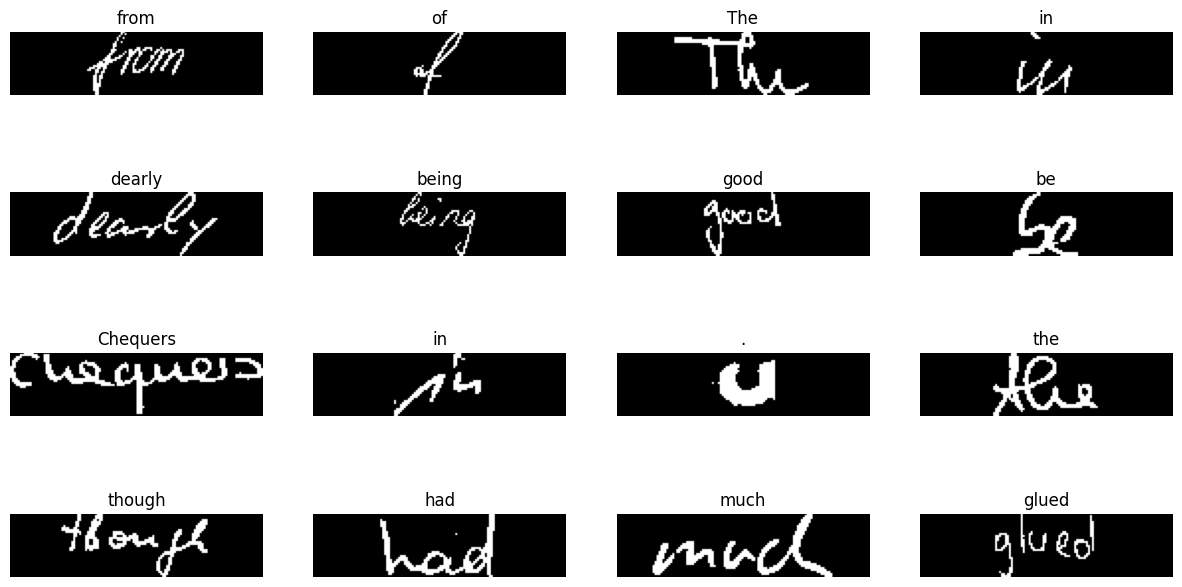

In [ ]:
_, subs = plt.subplots(4, 4, figsize=(15, 8))
for img, label, sb in zip(X[:16], Y[:16], subs.ravel()):
    sb.imshow(img, cmap="gray")
    sb.set_title(label)
    sb.axis("off")